In [1]:
#Questions:
#do we need to replicate 2nd table from Yeh et. al

In [2]:
#importing packages
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
import scipy.linalg as scl
import scikitplot as skplt
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import time
import seaborn as sn
sn.set(style="white") #fixes ugly backgrounds

In [3]:
def plot_confusion(y_real,y_pred,labs):
    if not labs:
        labs = np.unique(y_real)
    y_pred=y_pred.reshape(y_real.shape)
    confused = confusion_matrix(y_real,y_pred,sample_weight = None)
    df_cm = pd.DataFrame(confused,columns=labs, index=labs)

    df_cm.index.name = 'Actual'
    df_cm.columns.name ='Predicted'
    plt.figure(figsize=(3,3))
    sn.set(font_scale=1.4)
    ax = sn.heatmap(df_cm, cmap="inferno",annot=True, fmt='g',annot_kws={"size":16})
    first,second=ax.get_ylim()
    ax.set_ylim(first+0.5,0)
    plt.show()
    sn.set(style="white") #fixes ugly backgrounds

In [4]:
def two(y): #helper function for lift curve plotting
    y_two = np.zeros(len(y))
    for i in range(len(y)):
        y_two[i] = 1-y[i]
    return np.c_[y_two,y]

In [5]:
def bestCurve(defaults, total, defaultRate): #create best curve
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

In [6]:
def calc_area_ratio(pred,real):
    fig,ax = plt.subplots(1,1)
    y_te = two(pred)
    skplt.metrics.plot_cumulative_gain(real.ravel(), y_te,ax=ax)
    ax.grid(b=None)
    hh,ll=ax.get_legend_handles_labels()
    plt.close()
    defaults = sum(real == 1)
    total = len(real)
    defaultRate = defaults/total

    bestie=bestCurve(defaults,total,defaultRate)
    dia = np.linspace(0,1,15000)
    classi=hh[1].get_ydata()
    diff_c = np.sum(classi)-np.sum(dia)
    diff_b = np.sum(bestie[1])-np.sum(dia)+1 #adding a 1 on the end of bestie for dimensions?
    area_ratio = diff_c/diff_b
    return area_ratio,hh

In [7]:
def plot_lift(h,method):
    backg=np.array(Image.open("/home/janfki/Desktop/ML/Project2/Gains_logreg.jpg"))

    fig, ax2 = plt.subplots(1,1)
    ax2.plot(h[1].get_xdata(), h[1].get_ydata(),'r--',dashes=(3,3), lw=3, label='fitted curve')
    ax2.legend(loc='right')
    ax2.imshow(backg,aspect='auto',extent=[0,1,0,1.065])

    ax2.set_title(method)
    ax2.set_xlabel('Number of total data',fontweight='bold')
    ax2.set_ylabel('Cumulative number of target data',fontweight='bold')

    ax2.set_xticks((0,0.33,0.66,1))
    ax2.set_xticklabels((0,5000,10000,15000))
    ax2.set_yticks((0,0.15,0.307,0.46,0.614,0.77,0.92,1.065))
    ax2.set_yticklabels((0,500,1000,1500,2000,2500,3000,3500));  
    plt.show()

In [8]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [9]:
def sigmoid(s):
    return 1./(1.+np.exp(-s))

In [10]:
def Gradient(X,theta,y):
    return (X.T@(sigmoid(X@theta)-y))

In [11]:
def CostFunction(X,theta,y):
    y_pred= sigmoid(X@theta)
    y_pred_neg = sigmoid(-X@theta)
    cost__ = -y*np.log(y_pred)-(1-y)*np.log(y_pred_neg)
    cost_ = np.sum(cost__,axis=0)
#     print(cost__)
    return cost_/len(y)

In [12]:
"""
Takes two arrays of equal length and calculates the "Accuracy score"
"""
def Accuracy(t,y):
    assert len(t)==len(y), "y and y_pred dimensions do not match ({},{}).".format(len(t),len(y))
    s = [1 if i else 0 for i in np.equal(t,y)]
    return np.sum(s)/len(t)

In [13]:
"""
this function is pretty much stolen from
https://stackoverflow.com/questions/38157972/how-to-implement-mini-batch-gradient-descent-in-python
users Ash and dsachar
"""
def BatchIterator(X,y,batch_size,shuffle=True):
    assert X.shape[0]==y.shape[0], "X and y dimensions do not match ({},{}).".format(X.shape[0],y.shape[0])
    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
    for start_index in range(0,X.shape[0],batch_size):
        end_index = min(start_index+batch_size,X.shape[0])
        if shuffle:
            batch_indices = indices[start_index:end_index]
        else:
            batch_indices = slice(start_index,end_index)
        yield X[batch_indices],y[batch_indices]

In [14]:
def decreasing_lr(t):
        t0,t1 = 5,50
        return t0/(t+t1)

In [15]:
def ols_svd(X:np.ndarray)->np.ndarray:
    u, s, v = scl.svd(X)
    return np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))

In [60]:
def SGD(XTrain,yTrain,XTest,yTest,gd_method='GD',lr_method='const',init_method='rand',tol=1e-4,
        max_iters=10000,eta=0.00001,N_epochs=200,N_batches=100,Shuffle=True,verbose=True,seed=None):
    start_time = time.time()
    #INIT METHODS
    if seed != None:
        np.random.seed(seed)
    theta = np.random.randn(XTrain.shape[1],1) #if function is convex, start point wont matter, and this is fine
    
    #LR METHODS
    #     u,s,v = np.linalg.svd(XTrain_scaled.T@XTrain_scaled)
    #     eta = 2/np.max(s) # learning rate must be smaller than this in order to converge!  
    #evt svd igjen for max gamma

    ce_prev = 1e6
    ce=1e6+1
    
    #GD METHODS    
    if gd_method=='NR': #Newton-Raphson
        c=0
        theta=np.zeros((XTrain.shape[1],1))
        while abs(ce-ce_prev)>tol and c<max_iters:
            ce_prev=ce
            probs = sigmoid(XTrain@theta)
            W = np.zeros(yTrain.shape[0])
            for i in range(yTrain.shape[0]):
                W[i] = probs[i]*(1-probs[i])
            H = XTrain.T@np.diagflat(W)@XTrain
            Hinv=np.linalg.inv(H)          
            gradient = Gradient(XTrain,theta,yTrain)
            theta -= Hinv@gradient
            ce = CostFunction(XTrain,theta,yTrain) #used for convergence check
            c +=1
    if gd_method=='GD': #Gradient Descent
        c = 0
        while abs(ce-ce_prev)>tol and c<max_iters:
            ce_prev=ce
            gradient = Gradient(XTrain,theta,yTrain)
            theta -= eta*gradient*0.9999
            ce = CostFunction(XTrain,theta,yTrain) #used for convergence check
            c+=1

    if gd_method=='SGD': #Stochastic Gradient Descent
        for epoch in range(N_epochs):
            for i in range(XTrain.shape[0]):
                random_index = np.random.randint(XTrain.shape[0]) #allowing resampling, pretty much a jack-knife
                xi = XTrain[random_index:random_index+1]
                yi = yTrain[random_index:random_index+1]
                gradient = Gradient(xi,theta,yi)
                eta=decreasing_lr(epoch*N_batches+i)
                theta -=eta*gradient

    if gd_method =='SGDmb': #Stochastic Gradient Descent with minibatches
        for epoch in range(N_epochs):
            for batch in BatchIterator(XTrain,yTrain,int(XTrain.shape[0]/N_batches)+1,shuffle=Shuffle):
                X_batch,y_batch = batch
                gradient = Gradient(X_batch,theta,y_batch)
                theta -= eta*gradient
            eta=decreasing_lr(epoch) 

    if gd_method == 'skl': #scikit learn gradient descent
        sgd_clf = SGDClassifier(random_state=np.random.get_state()[1][0],loss='log',tol=1e-5,max_iter=500,penalty='none',alpha=0.,eta0=eta,learning_rate='constant',fit_intercept=False)
        sgd_clf.fit(XTrain,yTrain.ravel());
        theta = sgd_clf.coef_[0,:].reshape(-1,1)

    #CALC AND OUTPUT ACCURACY TEST
    y_pred_ = sigmoid(XTest@theta)
    y_out = sigmoid(XTest@theta)
#     y_pred_[y_pred_>=0.5]=1
#     y_pred_[y_pred_<0.5]=0    
    y_pred_[y_pred_>=0.18]=1
    y_pred_[y_pred_<0.18]=0
    #CALC AND OUTPUT ACCURACY TRAIN
    y_pred_t = sigmoid(XTrain@theta)
    y_out_tr = sigmoid(XTrain@theta)
#     y_pred_t[y_pred_t>=0.5]=1
#     y_pred_t[y_pred_t<0.5]=0
    y_pred_t[y_pred_t>=0.18]=1
    y_pred_t[y_pred_t<0.18]=0
    if verbose:
        labels=["N","D"]
        strings = ["Accuracy baseline (test): ","Accuracy of {} method (test): ".format(gd_method),"Area ratio of {} method (test): ".format(gd_method)]
        print("{:36s}   {:5f}".format(strings[0],1-Accuracy(yTest,np.zeros((yTest.shape)))))
        print("{:36s}   {:5f}".format(strings[1],1-Accuracy(yTest,y_pred_)))
        print("{:36s}   {:5f}".format(strings[2],calc_area_ratio(y_out,yTest)[0]))
        print("Confusion matrix for test data")
        plot_confusion(yTest,y_pred_,labels)
        print("Lift curve for test data")
        plot_lift(calc_area_ratio(y_out,yTest)[1],gd_method)
        strings_tr = ["Accuracy baseline (train): ","Accuracy of {} method (train): ".format(gd_method),"Area ratio of {} method (train): ".format(gd_method)]
        print("{:36s}   {:5f}".format(strings_tr[0],1-Accuracy(yTrain,np.zeros((yTrain.shape)))))
        print("{:36s}   {:5f}".format(strings_tr[1],1-Accuracy(yTrain,y_pred_t)))
        print("{:36s}   {:5f}".format(strings_tr[2],calc_area_ratio(y_out_tr,yTrain)[0]))
        print("Confusion matrix for train data")
        plot_confusion(yTrain,y_pred_t,labels)
        print("Lift curve for train data")
        plot_lift(calc_area_ratio(y_out_tr,yTrain)[1],gd_method)
        print("Runtime: {}s".format(time.time()-start_time))
        print("---------------------------------------")
    
    return y_out_tr,y_out

# one run of each method

In [45]:
XTrain,XTest,yTrain,yTest = ReadData()

Accuracy baseline (test):              0.221200
Accuracy of NR method (test):          0.185200
Area ratio of NR method (test):        0.459259
Confusion matrix for test data


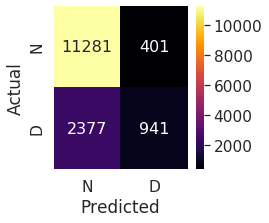

Lift curve for test data


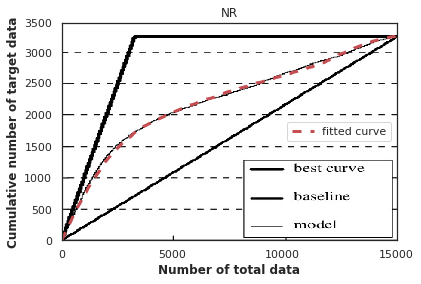

Accuracy baseline (train):             0.221200
Accuracy of NR method (train):         0.183533
Area ratio of NR method (train):       0.472948
Confusion matrix for train data


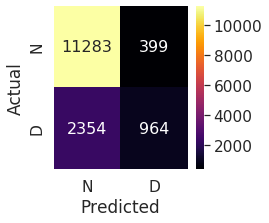

Lift curve for train data


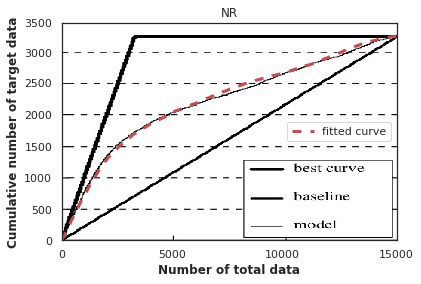

Runtime: 4.429611682891846s
---------------------------------------
Accuracy baseline (test):              0.221200
Accuracy of GD method (test):          0.191933
Area ratio of GD method (test):        0.432684
Confusion matrix for test data


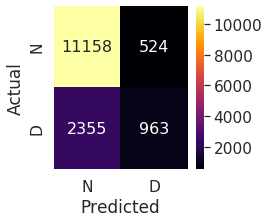

Lift curve for test data


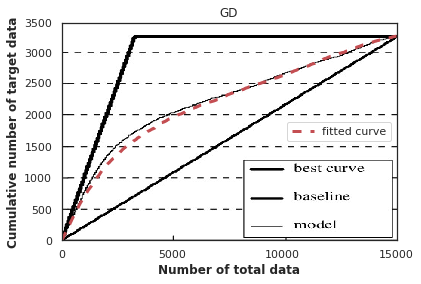

Accuracy baseline (train):             0.221200
Accuracy of GD method (train):         0.188200
Area ratio of GD method (train):       0.437247
Confusion matrix for train data


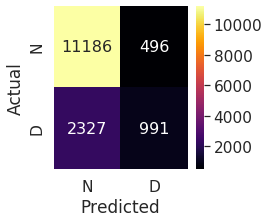

Lift curve for train data


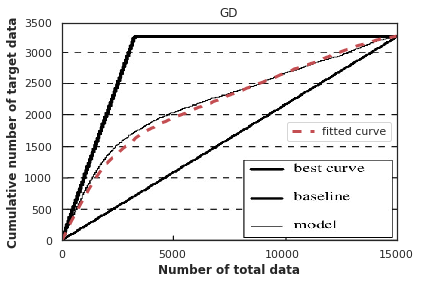

Runtime: 2.2815468311309814s
---------------------------------------
Accuracy baseline (test):              0.221200
Accuracy of SGD method (test):         0.185067
Area ratio of SGD method (test):       0.454908
Confusion matrix for test data


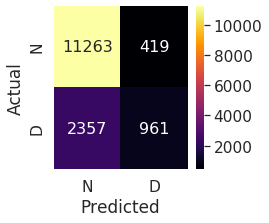

Lift curve for test data


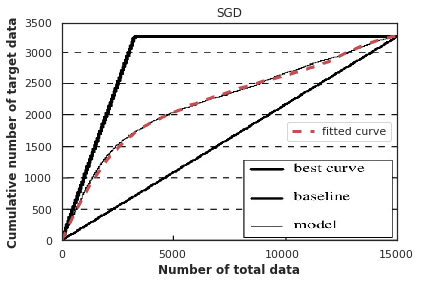

Accuracy baseline (train):             0.221200
Accuracy of SGD method (train):        0.183533
Area ratio of SGD method (train):      0.469413
Confusion matrix for train data


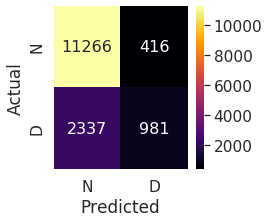

Lift curve for train data


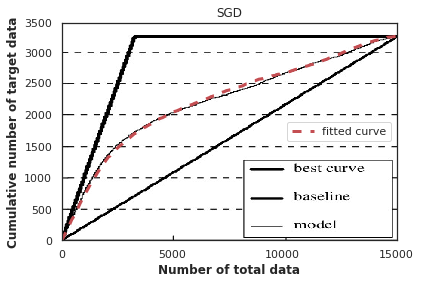

Runtime: 123.52318215370178s
---------------------------------------
Accuracy baseline (test):              0.221200
Accuracy of SGDmb method (test):       0.189000
Area ratio of SGDmb method (test):     0.450042
Confusion matrix for test data


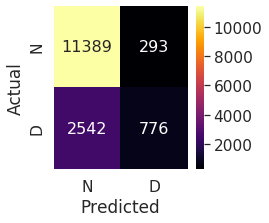

Lift curve for test data


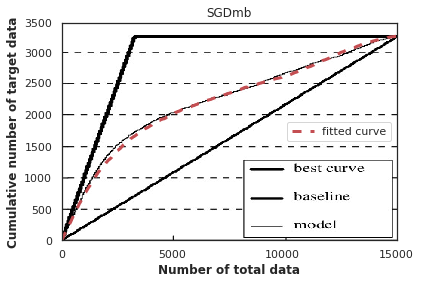

Accuracy baseline (train):             0.221200
Accuracy of SGDmb method (train):      0.190467
Area ratio of SGDmb method (train):    0.458283
Confusion matrix for train data


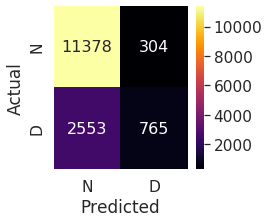

Lift curve for train data


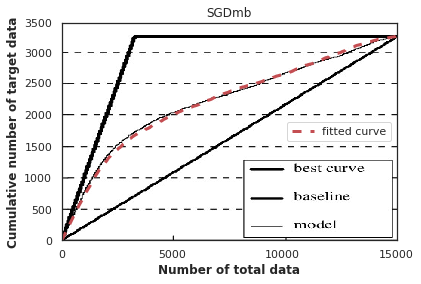

Runtime: 3.125755548477173s
---------------------------------------
Accuracy baseline (test):              0.221200
Accuracy of skl method (test):         0.189400
Area ratio of skl method (test):       0.450563
Confusion matrix for test data


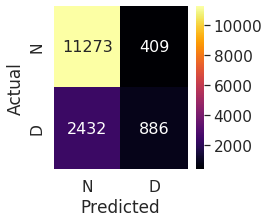

Lift curve for test data


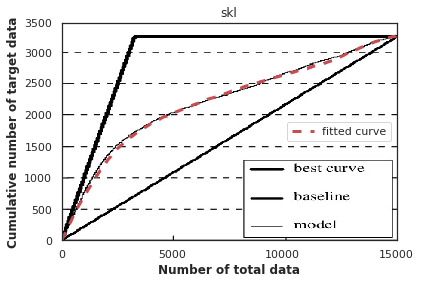

Accuracy baseline (train):             0.221200
Accuracy of skl method (train):        0.188133
Area ratio of skl method (train):      0.465089
Confusion matrix for train data


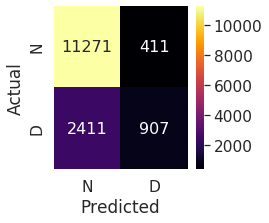

Lift curve for train data


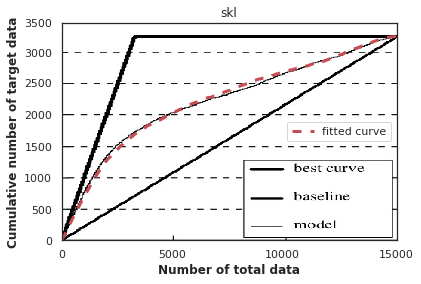

Runtime: 1.7428638935089111s
---------------------------------------


In [46]:
y_tr_NR,y_te_NR = SGD(XTrain,yTrain,XTest,yTest,gd_method='NR')
y_tr_GD,y_te_GD = SGD(XTrain,yTrain,XTest,yTest,gd_method='GD')
y_tr_SGD,y_te_SGD=SGD(XTrain,yTrain,XTest,yTest,gd_method='SGD')
y_tr_SGDmb,y_te_SGDmb=SGD(XTrain,yTrain,XTest,yTest,gd_method='SGDmb')
y_tr_skl,y_te_skl=SGD(XTrain,yTrain,XTest,yTest,gd_method='skl')

# running for 10 different initialization seeds
# to get a mean and std

In [19]:
#Read data and define methods and initialization seeds to run over
XTrain,XTest,yTrain,yTest = ReadData()
methods = ['NR','GD','SGD','SGDmb','skl']
seeds = [858,8,67,15,999,4,3334,5567,4747,897]

In [28]:
#run regressions
NR_tr = []
GD_tr=[]
SGD_tr=[]
SGDmb_tr=[]
skl_tr=[]

NR_te = []
GD_te=[]
SGD_te=[]
SGDmb_te=[]
skl_te=[]

y_tr = {'NR':NR_tr,'GD':GD_tr,'SGD':SGD_tr,'SGDmb':SGDmb_tr,'skl':skl_tr}
y_te = {'NR':NR_te,'GD':GD_te,'SGD':SGD_te,'SGDmb':SGDmb_te,'skl':skl_te}

for seed in seeds:
    print("Seed is {}.".format(seed))
    for method in methods:
        pred_train,pred_test =SGD(XTrain,yTrain,XTest,yTest,gd_method=method,seed=seed,verbose=False)
        y_tr[method].append(pred_train)
        y_te[method].append(pred_test)

Seed is 858.
Seed is 8.
Seed is 67.
Seed is 15.
Seed is 999.
Seed is 4.
Seed is 3334.
Seed is 5567.
Seed is 4747.
Seed is 897.


In [34]:
defaults = sum(yTest == 1)
total = len(yTest)
defaultRate = defaults/total

bestie=bestCurve(defaults,total,defaultRate)

for method in methods:
    print(method)
    acc_te =[]
    acc_tr=[]
    ar_tr = []
    ar_te = []
#     plt.figure()
    for i in range(len(y_te[method])):
        y_pred_ = np.copy(y_te[method][i])
        y_pred_[y_pred_>=0.5]=1
        y_pred_[y_pred_<0.5]=0
        acc_te.append(1-Accuracy(yTest,y_pred_))

        y_pred_t = np.copy(y_tr[method][i])
        y_pred_t[y_pred_t>=0.5]=1
        y_pred_t[y_pred_t<0.5]=0        
        acc_tr.append(1-Accuracy(yTrain,y_pred_t))
        
        fig,ax = plt.subplots(1,1)
        ytt=two(np.squeeze(y_te[method][i]))
        skplt.metrics.plot_cumulative_gain(yTest.ravel(), ytt,ax=ax)
        ax.grid(b=None)
        h,l=ax.get_legend_handles_labels()

        dia = np.linspace(0,1,15000)
        classi=h[1].get_ydata()
        diff_c = np.sum(classi)-np.sum(dia)
        diff_b = np.sum(bestie[1])-np.sum(dia)+1 #adding a 1 on the end of bestie for dimensions?
        ar_te.append(diff_c/diff_b)
        plt.close()

        fig,ax = plt.subplots(1,1)
        ytt=two(y_tr[method][i])
        skplt.metrics.plot_cumulative_gain(yTrain.ravel(), ytt,ax=ax)
        ax.grid(b=None)
        h,l=ax.get_legend_handles_labels()
        
        dia = np.linspace(0,1,15000)
        classi=h[1].get_ydata()
        diff_c = np.sum(classi)-np.sum(dia)
        diff_b = np.sum(bestie[1])-np.sum(dia)+1 #adding a 1 on the end of bestie for dimensions?
        ar_tr.append(diff_c/diff_b)        
        plt.close()
    
    print("err_tr ","mean",np.mean(acc_tr).round(3),"std",np.std(acc_tr).round(4))
    print("err_te ","mean",np.mean(acc_te).round(3),"std",np.std(acc_te).round(4))
    print("area_tr","mean",np.mean(ar_tr).round(3),"std",np.std(ar_tr).round(4))
    print("area_te","mean",np.mean(ar_te).round(3),"std",np.std(ar_te).round(4))



NR
err_tr  mean 0.184 std 0.0
err_te  mean 0.185 std 0.0
area_tr mean 0.473 std 0.0
area_te mean 0.459 std 0.0
GD
err_tr  mean 0.191 std 0.0051
err_te  mean 0.192 std 0.0049
area_tr mean 0.44 std 0.0081
area_te mean 0.433 std 0.008
SGD
err_tr  mean 0.184 std 0.0006
err_te  mean 0.185 std 0.0005
area_tr mean 0.471 std 0.0011
area_te mean 0.457 std 0.0011
SGDmb
err_tr  mean 0.189 std 0.0071
err_te  mean 0.19 std 0.0065
area_tr mean 0.442 std 0.0336
area_te mean 0.427 std 0.031
skl
err_tr  mean 0.188 std 0.0001
err_te  mean 0.189 std 0.0001
area_tr mean 0.465 std 0.0
area_te mean 0.451 std 0.0


# plot ROC, and consider cut off

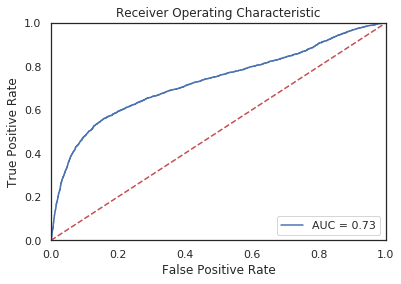

In [57]:
fpr,tpr,tresh= sklearn.metrics.roc_curve(yTest,y_te_NR)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % sklearn.metrics.roc_auc_score(yTest,y_te_NR))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The plot indicates that to reduce false positives, we must move to the left along the x-axis. It seems the largest gain of True pos is over at around 0.18 FPR.
Setting the cut off to this results in the following confusion matrix

Accuracy baseline (test):              0.221200
Accuracy of NR method (test):          0.393200
Area ratio of NR method (test):        0.459259
Confusion matrix for test data


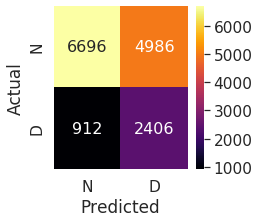

Lift curve for test data


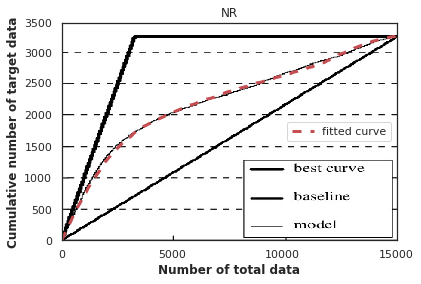

Accuracy baseline (train):             0.221200
Accuracy of NR method (train):         0.390667
Area ratio of NR method (train):       0.472948
Confusion matrix for train data


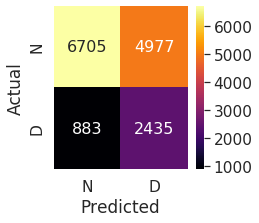

Lift curve for train data


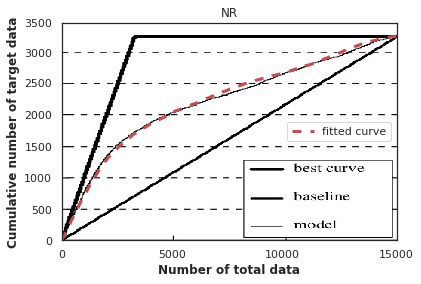

Runtime: 2.1653738021850586s
---------------------------------------


In [61]:
y_tr_NR,y_te_NR = SGD(XTrain,yTrain,XTest,yTest,gd_method='NR')